In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import pickle
import numpy as np

In [3]:
def get_cm_detections_stats(obj, method = 'ddm'):

    tp, fp, fn, tn = obj[f'{method}_detected']

    if (2*tp + fp + fn) == 0:
        f1 = 1
    else:
        f1 = 2 *tp / (2*tp + fp + fn)
    #detecteds.append(1 if len(obj[f'{method}_detected_batch'])>0 else 0)
    # Condition on altered
    detected = 1 if obj[f'{method}_detected'][0]>0 else 0
    return [tp, fp, fn, tn], f1, detected


In [4]:
def get_predictions(obj, method = 'ddm'):

    tp, fp, fn, tn = obj[f'{method}_detected'] 
    return tp+fp


In [5]:
def get_num_pts_predictions(obj, method = 'ddm'):
 
    return sum([len(v) for v in obj[f'{method}_detected_batch'].values()])

In [6]:
import re


def get_support_bucket(fname):
    try:
        return tuple(map(float, re.findall(r"support-((?:0|1)\.\d+)-((?:0|1)\.\d+)-", fname)[0]))
    except:
        print(fname)
        raise ValueError

In [7]:
bucket_results = {}

In [8]:
def get_bucket_results(input_dir, par_configuration,  method, threshold=0):
    
    input_dir = os.path.join(input_dir, method, str(par_configuration))

    input_files = glob(f"{input_dir}/*pkl")


    predictions = []
    raw_predictions = []
    supports = []

    bucket_results = {}
    raw_bucket_results = {}

    for filename in input_files:
        with open(filename, "rb") as f:
            obj = pickle.load(f)
            #pred = get_predictions(obj, method = method)
            pred = get_num_pts_predictions(obj, method = method)

            predictions.append(pred > threshold)
            raw_predictions.append(pred)
            supports.append(get_support_bucket(obj['file_basename']))

    for idx in range(len(supports)):
        bucket  = supports[idx]
        if bucket not in bucket_results:
            bucket_results[bucket] = []
            raw_bucket_results[bucket] = []
        bucket_results[bucket].append(predictions[idx])
        raw_bucket_results[bucket].append(raw_predictions[idx])

    return bucket_results, raw_bucket_results


In [9]:
dataset = 'adult'
# dataset = 'celeba'


if dataset == 'celeba':
    checkpoint = 'resnet50'
    input_base_dir = 'results-drift-overall'

elif dataset == 'adult':
    checkpoint = 'xgb-adult'
    input_base_dir = 'results-drift-overall'

else:
    raise ValueError(f"Unknown dataset {dataset}")

In [10]:
import pathlib

output_dir = 'overall_summary_buckets_results'
p = pathlib.Path(output_dir)
p.mkdir(parents=True, exist_ok=True)

In [11]:
output_config = 'may_17'

In [12]:
summary_bucket = {}

from functools import reduce
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, confusion_matrix


methods = ['ddm', 'adwin', 'eddm', 'hddma', 'fet', 'chi2',  'pagehinkley', 'kswin'] # 'hddm_w', 
accuracies = {}
precisions = {}
recalls = {}
f1s = {}
rocs = {}
ground_truth_pred = {}
fprs = {}
confusion_matrixes = {}
fnrs = {}

count_size = {}

supports = None
threshold = 0


min_num_instances = 500
delta = 0.002

for method in methods :
    if method == 'ddm':
        settings = [4000]
    elif method == 'adwin':
        settings = [0.001] #[0.002, 0.004, 0.05, 0.1]
    elif method == 'hddma' or method == 'hddmw':
        settings = [0.0001] #[0.0005, 0.001, 0.002, 0.004, 0.05, 0.1]
    elif method == "chi2":
        settings = [0.001, 0.01, 0.05]  # defaul pvalue 0.05
    elif method == "fet":
        settings = [0.001, 0.01, 0.05] # defaul pvalue 0.05
    elif method == "kswin":
        settings = [500, 1000] if dataset=='celeba' else [500, 1000, 2000, 2500, 3000, 4000]
    elif method == "pagehinkley":
        settings = [4000]
    elif method == "eddm":
        settings = ['def']
    else:
        settings = [None]
    
    
    for  par_configuration in settings:

        input_dir = os.path.join(input_base_dir, f'{checkpoint}', "pos")
        pos_summary_bucket, pos_raw_summary_buckets = get_bucket_results(input_dir, par_configuration, method, threshold=threshold)

        if pos_summary_bucket == {}:
            raise ValueError(f"Empty pos_summary_bucket for {method} {par_configuration}")
        input_dir = os.path.join(input_base_dir, f'{checkpoint}', "neg")
        neg_summary_bucket, neg_raw_summary_buckets = get_bucket_results(input_dir, par_configuration,  method , threshold=threshold)

        if neg_summary_bucket == {}:
            raise ValueError(f"Empty neg_summary_bucket for {method} {par_configuration}")


        if supports is None:
            supports = sorted([ a for a in pos_summary_bucket.keys()])
        else:
            
            #assert supports == sorted([ a for a in pos_summary_bucket.keys()])
            if supports != sorted([ a for a in pos_summary_bucket.keys()]):
                continue

        y_pred_neg = reduce(lambda a, b: a + b, neg_summary_bucket.values())
        y_pred_raw_neg = reduce(lambda a, b: a + b, neg_raw_summary_buckets.values())
        y_true_neg = [0] * len(y_pred_neg)

        method_setting_name = f'{method}_{par_configuration}' if par_configuration is not None else method

        for bucket in supports:
            max_len = min(50, len(pos_summary_bucket[bucket]))
            y_true_pos = [1] * max_len
            y_pred_raw_pos = pos_raw_summary_buckets[bucket][:max_len]
            y_pred_pos = pos_summary_bucket[bucket][:max_len]

            y_true = y_true_pos + [0] * len(y_pred_pos)
            y_pred = y_pred_pos + y_pred_neg[:len(y_pred_pos)]
            y_pred_raw = y_pred_raw_pos + y_pred_raw_neg[:len(y_pred_pos)]

            if method_setting_name not in accuracies:
                accuracies[method_setting_name] = []
                precisions[method_setting_name] = []
                recalls[method_setting_name] = []
                f1s[method_setting_name] = []
                rocs[method_setting_name] = []
                count_size[method_setting_name] = []
                ground_truth_pred[method_setting_name] = {}
                fprs[method_setting_name] = []
                fnrs[method_setting_name] = []
                confusion_matrixes[method_setting_name] = []

            accuracies[method_setting_name].append(accuracy_score(y_true, y_pred))
            precisions[method_setting_name].append(precision_score(y_true, y_pred, zero_division=0))
            recalls[method_setting_name].append(recall_score(y_true, y_pred, zero_division=0))
            f1s[method_setting_name].append(f1_score(y_true, y_pred, zero_division=0))
            rocs[method_setting_name].append(roc_curve(y_true, y_pred_raw))
            count_size[method_setting_name].append(max_len)
            tn, fp, fn, tp =  confusion_matrix(y_true, y_pred).ravel()
            confusion_matrixes[method_setting_name].append([tn, fp, fn, tp])
            fprs[method_setting_name].append(fp/(fp+tn))
            fnrs[method_setting_name].append(fn/(fn+tp))


            ground_truth_pred[method_setting_name][bucket] = {'y_true': y_true, 'y_pred_raw': y_pred_raw}

In [13]:
import pandas as pd

f1s_mean = {method: np.mean(values) for method, values in f1s.items()}
acc_mean = {method: np.mean(values) for method, values in accuracies.items()}
pd.DataFrame([f1s_mean, acc_mean], index= ['F1', 'acc']).T.sort_index().round(4)


,F1,acc
adwin_0.001,0.5802,0.7732
chi2_0.001,0.5393,0.7394
chi2_0.01,0.6700,0.7743
chi2_0.05,0.6710,0.6289
ddm_4000,0.7971,0.8645
eddm_def,0.6845,0.5579
fet_0.001,0.5697,0.7574
fet_0.01,0.6885,0.7760
fet_0.05,0.7168,0.7104
hddma_0.0001,0.5706,0.7602


In [14]:
from collections import Counter
set(y_pred_raw), len(y_pred_raw), Counter(y_pred_raw)

({0, 2, 3}, 34, Counter({3: 10, 2: 7, 0: 17}))

In [15]:
with open(os.path.join(output_dir, f'summary_bucket_results_overall_{dataset}_{output_config}.pkl'), 'wb') as f:
    pickle.dump({'accuracies': accuracies, 'precisions': precisions, 'recalls': recalls, 'f1s': f1s, 'rocs': rocs, 'supports': supports, 'fprs': fprs, 'fnrs': fnrs, 'cm': confusion_matrixes}, f)

In [16]:
save_other = True

if save_other:
    with open(os.path.join(output_dir, f'true_y_pred_results_overall_{dataset}_{output_config}.pkl'), 'wb') as f:
        pickle.dump(ground_truth_pred, f)

In [17]:
print(os.path.join(output_dir, f'true_y_pred_results_overall_{dataset}_{output_config}.pkl'))

overall_summary_buckets_results/true_y_pred_results_overall_adult_may_17.pkl


In [18]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
with open(os.path.join(output_dir, f'summary_bucket_results_overall_{dataset}_{output_config}.pkl'), 'rb') as f:
    summary_bucket = pickle.load(f)

In [ ]:
import pandas as pd

f1s_mean = {method: np.mean(values) for method, values in f1s.items()}
acc_mean = {method: np.mean(values) for method, values in accuracies.items()}
pd.DataFrame([f1s_mean, acc_mean], index= ['F1', 'acc']).T.sort_index().round(4)


,F1,acc
adwin_0.001,0.5802,0.7732
chi2_0.001,0.5393,0.7394
chi2_0.01,0.6700,0.7743
chi2_0.05,0.6710,0.6289
ddm_4000,0.7971,0.8645
eddm_def,0.6845,0.5579
fet_0.001,0.5697,0.7574
fet_0.01,0.6885,0.7760
fet_0.05,0.7168,0.7104
hddma_0.0001,0.5706,0.7602


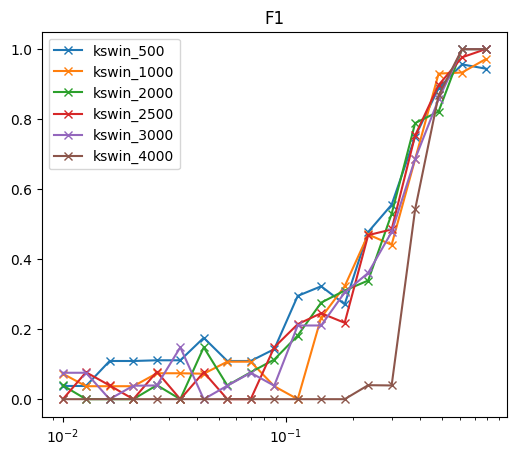

In [ ]:

methods = ['kswin']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(methods), figsize=(6*len(methods),5), sharey=True)
for e, method in enumerate(methods):
    
    for k, v in f1s.items():
        if method in k[:len(method)]:
            ax.plot([ a for a,b in supports], v, label=k, marker='x')
            ax.set_xscale("log")
            ax.set_title("F1")
    ax.legend()


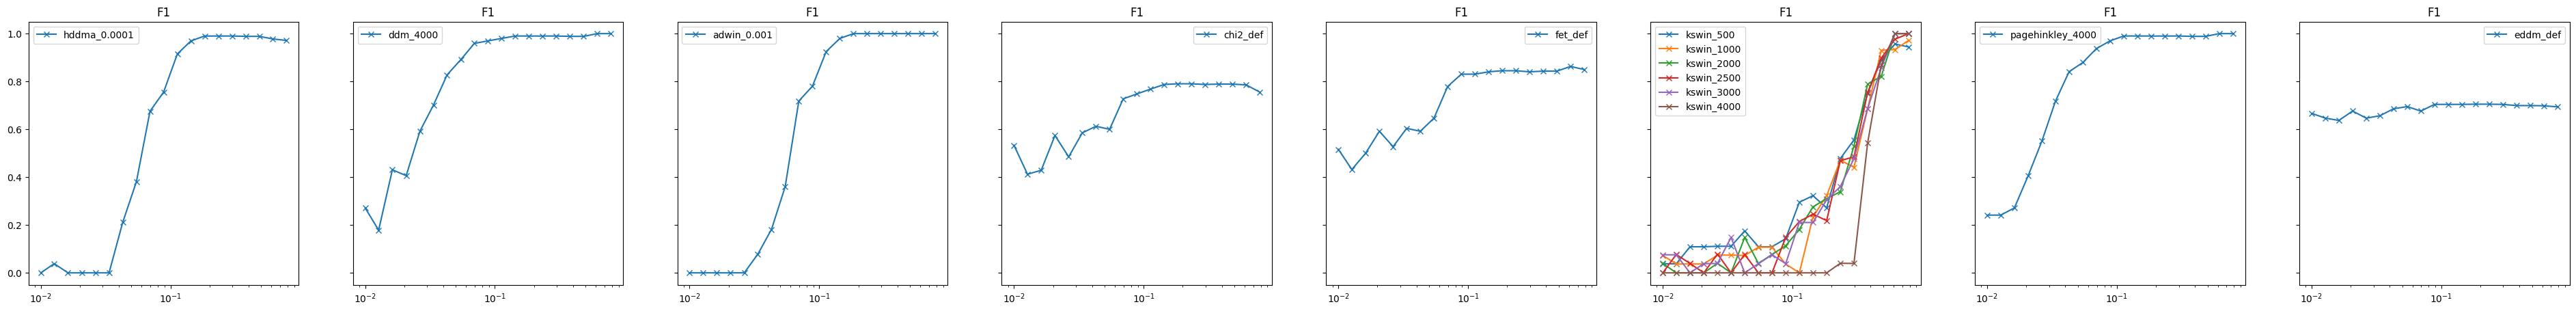

In [ ]:

methods = ['hddma', 'ddm', 'adwin', 'chi2', 'fet', 'kswin', 'pagehinkley', 'eddm']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(methods), figsize=(6*len(methods),5), sharey=True)
for e, method in enumerate(methods):
    
    for k, v in f1s.items():
        if method in k[:len(method)]:
            ax[e].plot([ a for a,b in supports], v, label=k, marker='x')
            ax[e].set_xscale("log")
            ax[e].set_title("F1")
    ax[e].legend()


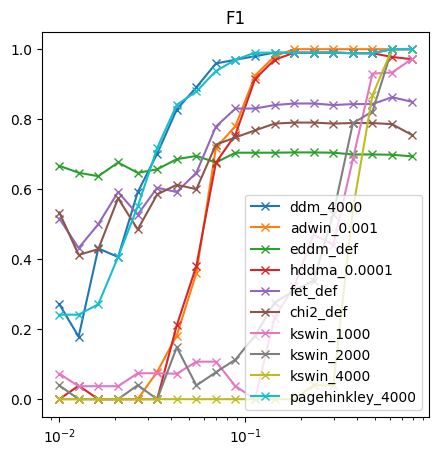

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5,5))


for k, v in f1s.items():
    ax.plot([ a for a,b in supports], v, label=k, marker='x')
    ax.set_title("F1")
    ax.set_xscale("log")
ax.legend()

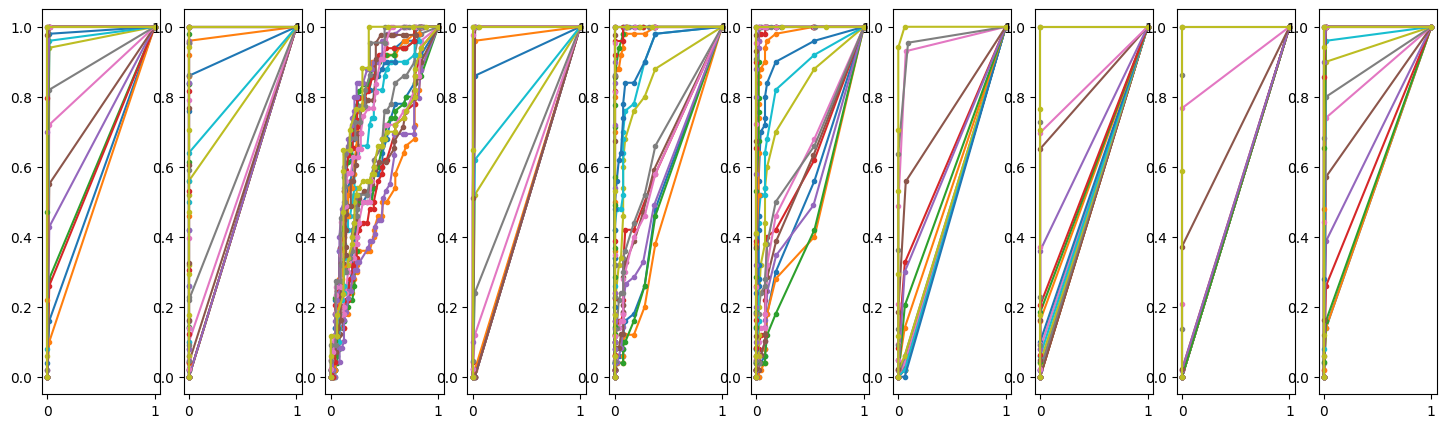

In [ ]:
fig, ax = plt.subplots(1, len(rocs), figsize=(18,5))

for i, method in enumerate(rocs):
    # plot roc curves for all buckets
    for j in range(len(supports)):
        fpr, tpr, _ = rocs[method][j]
        ax[i].plot(fpr, tpr, marker='.')